In [1]:
# basics
import pandas as pd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time

# creating train and test sets
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# classifiers
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# evaluating models
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error

# regressors
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge

# optimising models and fine tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# neural network
import tensorflow as tf

In [2]:
def get_train_test():
    
    '''GET DATASET FROM CSV FILE, REMOVE OUTLIERS AND DROP USELESS COLUMNS,
    ONLY KEEP FILTERS AND REDSHIFTS OF GALAXIES!! (IGNORE OTHER OBJECTS)'''
    
    # load
    df = pd.read_csv("star_classification.csv")
    # remove outliers (we noticed some objects had values for u/z/g/redshift below zero)
    outliers = df[(df["u"] <= 0)  
                | (df["z"] <= 0) 
                | (df["g"] <= 0)]

    # drop the row corresponding to the outlier
    df = df.drop(outliers.index, axis=0)
    
    # we drop the data we are not interested in and which won't be useful
    # expect isotropic universe -> also drop position in sky
    df = df.drop(
        columns=["alpha", "delta", "obj_ID", "fiber_ID", "MJD", "plate", "spec_obj_ID", 
                 "field_ID", "cam_col", "rerun_ID", "run_ID"], axis=1)
    
    # replace and drop all NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(axis=0)
    
    # stratified split
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    for train_val_index, test_index in split.split(df, df["class"]):
        strat_train_val_set = df.loc[train_val_index]
        strat_test_set = df.loc[test_index]
    
    # replace and drop all NaN
    strat_train_val_set = strat_train_val_set.reset_index(drop=True)
    strat_train_val_set = strat_train_val_set.replace([np.inf, -np.inf], np.nan)
    strat_train_val_set = strat_train_val_set.dropna(axis=0)
    
    # stratified split
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    for train_index, val_index in split.split(strat_train_val_set, strat_train_val_set["class"]):
        strat_train_set = strat_train_val_set.loc[train_index]
        strat_val_set = strat_train_val_set.loc[val_index]
    
    return strat_train_set, strat_test_set, strat_val_set, df

train, test, val, df = get_train_test()

# replace and drop all NaN
train = train.reset_index(drop=True)
train = train.replace([np.inf, -np.inf], np.nan)
train = train.dropna(axis=0)

# replace and drop all NaN
test = test.reset_index(drop=True)
test = test.replace([np.inf, -np.inf], np.nan)
test = test.dropna(axis=0)

# replace and drop all NaN
val = val.reset_index(drop=True)
val = val.replace([np.inf, -np.inf], np.nan)
val = val.dropna(axis=0)

# seperate measurements (x) with class(y) in train set
x_train = train.drop(columns=["class"], axis=1)
y_train = train["class"]

# seperate measurements (x) with class(y) in val set
x_val = val.drop(columns=["class"], axis=1)
y_val = val["class"]

# seperate measurements (x) with class(y) in test set
x_test = test.drop(columns=["class"], axis=1)
y_test = test["class"]

# selecting only galaxies
y_train_galaxy = (y_train == "GALAXY")
y_val_galaxy = (y_val == "GALAXY")
y_test_galaxy = (y_test == "GALAXY")

In [3]:
def plot_loss_acc(loss, acc, val_loss, val_acc, title=""):

    fig = plt.figure(figsize=[24,6])

    plt.subplot(1,2,1)
    plt.plot(loss, label="Loss training set")
    plt.plot(val_loss, label="Loss validation set")
    plt.grid(True)
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(acc, label="Accuracy training set")
    plt.plot(val_acc, label="Accuracy validation set")
    plt.grid(True)
    plt.title("Accuracy")
    plt.legend()
    
    fig.suptitle(title)
    
    return

In [61]:
#binary
binary_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(6,)),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # activation function allows to bound outputs between [0,1] here with sigmoid
])

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
binary_model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
binary_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 8)                 56        
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [62]:
callback_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
history = binary_model.fit(x_train, y_train_galaxy, 
                           epochs = 100, 
                           batch_size = 64,
                           validation_data=(x_val,y_val_galaxy), 
                           callbacks=[callback_earlystop]
                          )

Epoch 1/100
1129/1129 [==============================] - 2s 1ms/step - loss: 0.5497 - accuracy: 0.7358 - val_loss: 0.4777 - val_accuracy: 0.7949
Epoch 2/100
1129/1129 [==============================] - 1s 1ms/step - loss: 0.4241 - accuracy: 0.8236 - val_loss: 0.3918 - val_accuracy: 0.8417
Epoch 3/100
1129/1129 [==============================] - 1s 1ms/step - loss: 0.3792 - accuracy: 0.8391 - val_loss: 0.3727 - val_accuracy: 0.8363
Epoch 4/100
1129/1129 [==============================] - 1s 1ms/step - loss: 0.3439 - accuracy: 0.8466 - val_loss: 0.3055 - val_accuracy: 0.8706
Epoch 5/100
1129/1129 [==============================] - 1s 1ms/step - loss: 0.2682 - accuracy: 0.9017 - val_loss: 0.2195 - val_accuracy: 0.9407
Epoch 6/100
1129/1129 [==============================] - 1s 1ms/step - loss: 0.2077 - accuracy: 0.9387 - val_loss: 0.1995 - val_accuracy: 0.9471
Epoch 7/100
1129/1129 [==============================] - 1s 1ms/step - loss: 0.1870 - accuracy: 0.9435 - val_loss: 0.1721 - val_ac

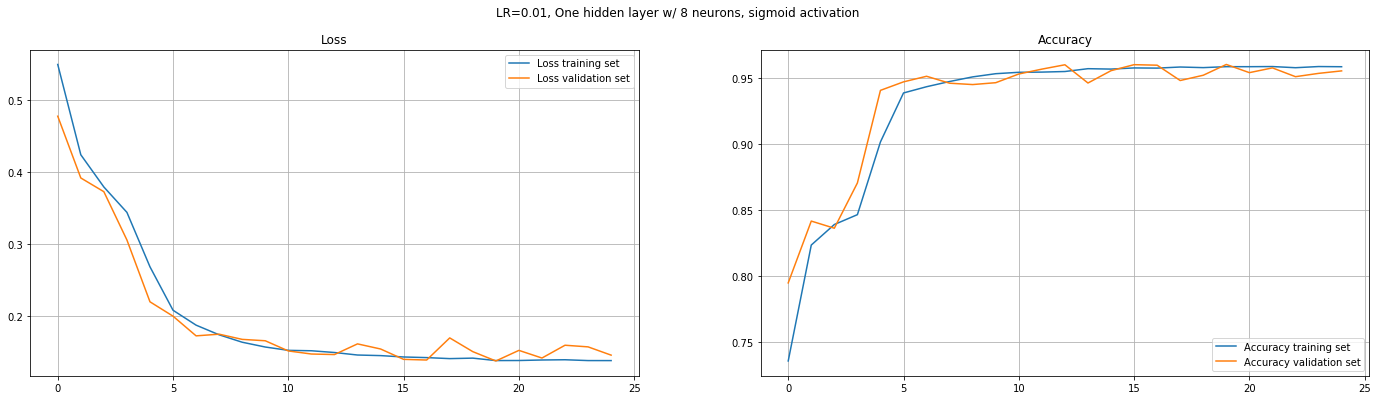

In [63]:
hist_loss = history.history["loss"]
hist_acc = history.history["accuracy"]

hist_val_loss = history.history["val_loss"]
hist_val_acc = history.history["val_accuracy"]

plot_loss_acc(hist_loss, hist_acc, hist_val_loss, hist_val_acc, title="LR=0.01, One hidden layer w/ 8 neurons, sigmoid activation")

In [18]:
#multiclass
multiclass_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(6,)),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
    # activation function allows to bound outputs between [0,1] here with sigmoid
])

multiclass_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
multiclass_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 56        
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


In [20]:
# copy the classes for train and val
y_train_temp = y_train.copy()
y_val_temp = y_val.copy()

from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'class' column 
y_train_temp_array = np.array(y_train_temp).reshape(-1, 1)
encoder_train = pd.DataFrame(encoder.fit_transform(y_train_temp_array).toarray())
encoder_train.columns = ['GALAXY', 'QSO', 'STAR']

#perform one-hot encoding on 'class' column 
y_val_temp_array = np.array(y_val_temp).reshape(-1, 1)
encoder_val = pd.DataFrame(encoder.fit_transform(y_val_temp_array).toarray())
encoder_val.columns = ['GALAXY', 'QSO', 'STAR']

In [21]:
callback_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
history = multiclass_model.fit(x_train, encoder_train, 
                           epochs = 100, 
                           batch_size = 32,
                           validation_data=(x_val, encoder_val), 
                           callbacks=[callback_earlystop]
                          )

Epoch 1/100
2258/2258 [==============================] - 3s 1ms/step - loss: 0.7988 - accuracy: 0.6534 - val_loss: 0.5940 - val_accuracy: 0.7980
Epoch 2/100
2258/2258 [==============================] - 3s 1ms/step - loss: 0.5251 - accuracy: 0.8227 - val_loss: 0.4825 - val_accuracy: 0.8332
Epoch 3/100
2258/2258 [==============================] - 3s 1ms/step - loss: 0.4572 - accuracy: 0.8381 - val_loss: 0.4371 - val_accuracy: 0.8445
Epoch 4/100
2258/2258 [==============================] - 3s 1ms/step - loss: 0.4168 - accuracy: 0.8474 - val_loss: 0.4012 - val_accuracy: 0.8506
Epoch 5/100
2258/2258 [==============================] - 3s 1ms/step - loss: 0.3822 - accuracy: 0.8552 - val_loss: 0.3694 - val_accuracy: 0.8561
Epoch 6/100
2258/2258 [==============================] - 3s 1ms/step - loss: 0.3486 - accuracy: 0.8655 - val_loss: 0.3402 - val_accuracy: 0.8769
Epoch 7/100
2258/2258 [==============================] - 3s 1ms/step - loss: 0.3159 - accuracy: 0.8812 - val_loss: 0.3061 - val_ac

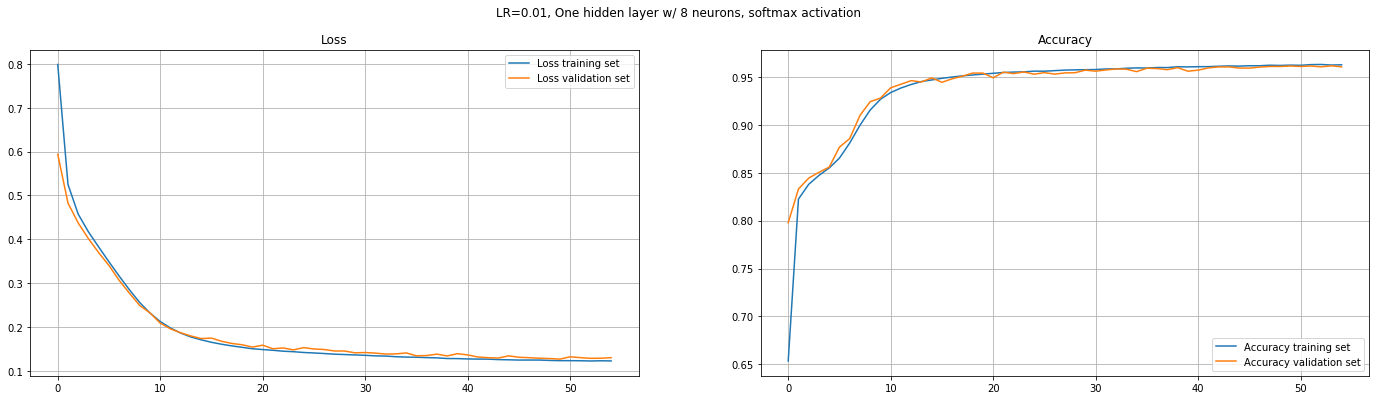

In [23]:
hist_loss = history.history["loss"]
hist_acc = history.history["accuracy"]

hist_val_loss = history.history["val_loss"]
hist_val_acc = history.history["val_accuracy"]

plot_loss_acc(hist_loss, hist_acc, hist_val_loss, hist_val_acc, title="LR=0.01, One hidden layer w/ 8 neurons, softmax activation")